In [4]:
# Builds basic transmission screens for nulling

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import rotate as scipy_rotate

%matplotlib inline

In [ ]:
## Definitions and parameters

In [3]:
# define an extended apertures

## ## TODO: IMPLEMENT LATER

# Parameters for the grid and circles
N = 200  # size of the image, e.g., 200x200
radius = 10  # radius of each circle, in pixels
d = 70       # distance from center to the center of each circle (in pixels)
pixel_scale = 0.01  # meters per pixel ('pixel' here is the pixel in the image corresponding to the aperture, not nec. the detector)

# Create grid coordinates (x and y)
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Two circles, equidistant from center along the x-axis
circle1 = ((X - d/2)**2 + Y**2) < radius**2
circle2 = ((X + d/2)**2 + Y**2) < radius**2

# First slice: binary mask of the two circles (OR them together)
aperture = np.zeros((N, N), dtype=float)
aperture[(circle1 | circle2)] = 1

# Slices 2 and 3: x and y coordinates in meters
x_m = (X) * pixel_scale
y_m = (Y) * pixel_scale

# Make the 3D array
aperture_cube = np.zeros((3, N, N), dtype=float)
aperture_cube[0] = aperture
aperture_cube[1] = x_m
aperture_cube[2] = y_m


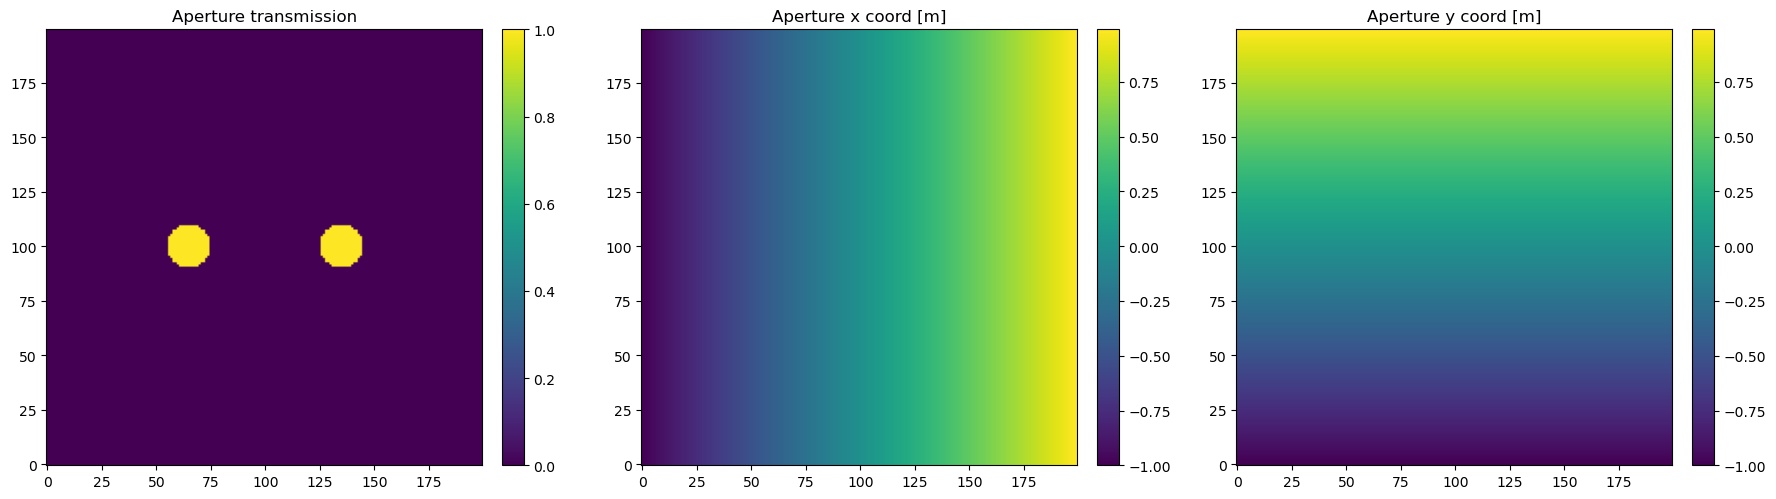

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(aperture_cube[0], origin='lower')
axes[0].set_title('Aperture transmission')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(aperture_cube[1], origin='lower')
axes[1].set_title('Aperture x coord [m]')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(aperture_cube[2], origin='lower')
axes[2].set_title('Aperture y coord [m]')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [5]:
# define the astrophysical scene

pixel_scale_onsky = 0.0107  # arcseconds per detector pixel

# cube to hold the scene and on-sky coordinates
astro_cube = np.zeros((3, N, N), dtype=float)

# perfect on-sky scene
astro_scene = np.zeros((N, N), dtype=float)

# simple off-center star
row, col = 53, 48
astro_scene[row:row+40, col:col+20] = 1

# Create on-sky grid coordinates (x and y) in arcseconds
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Slices 2 and 3: x and y coordinates in meters
x_asec = (X) * pixel_scale_onsky
y_asec = (Y) * pixel_scale_onsky

# add the coordinates
astro_cube[0] = astro_scene
astro_cube[1] = y_asec
astro_cube[2] = x_asec

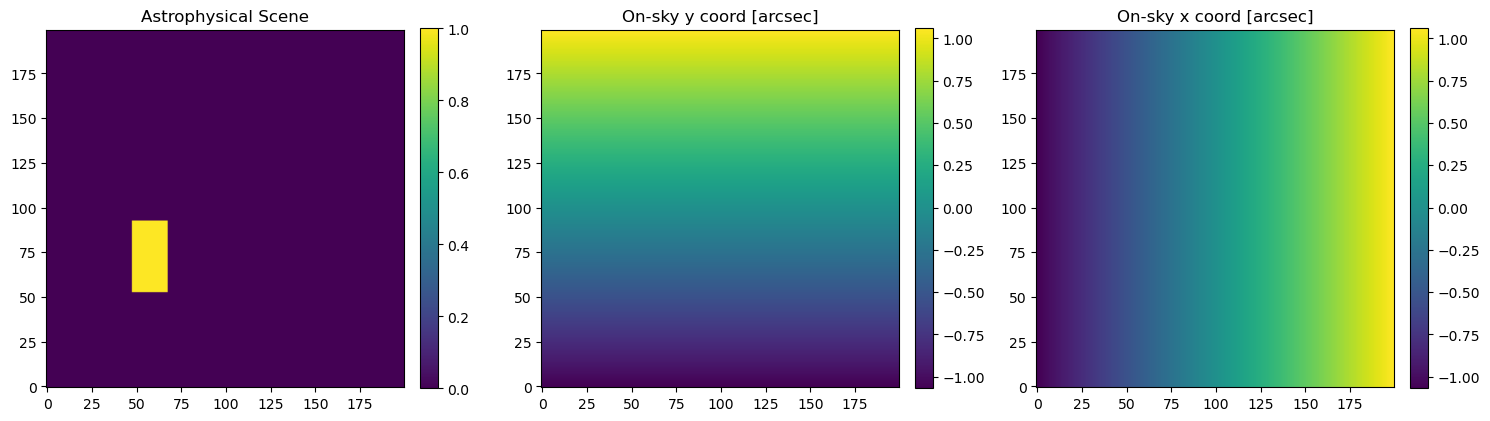

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(astro_cube[0], origin='lower')
axes[0].set_title('Astrophysical Scene')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(astro_cube[1], origin='lower')
axes[1].set_title('On-sky y coord [arcsec]')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(astro_cube[2], origin='lower')
axes[2].set_title('On-sky x coord [arcsec]')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# apply the transmission screens to the astrophysical scene


In [ ]:
## ## Instrument response

In [7]:
def inst_response_and_transmission(A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m, plot=False):
    # Complex instrument respose over the sky (R_theta_vec,Dannert 2025 Eqn. B12, ignoring polarization for now)
    # ... and the on-sky transmission

    # N.b. this is the interferometric response (it can have negative values), not a transmission map 

    '''
    INPUTS:
    A_vec: array of amplitudes
    x_vec: array of vectors of aperture positions (y,x) [m]
    phi_dc_vec_rad: array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec
    wavel_m: wavelength in meters
    # incl_comp_transmission: boolean, if True, include the transmissions of the component baselines in slice 1 to -3
    plot: boolean, if True, plot the instrument response

    OUTPUT:
    complex_instrument_response: instrument response over the sky; slices are
      [0] = total instrument response
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    transmission_instrument_response: instrument response over the sky; slices are
      [0] = total on-sky transmission
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    '''

    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec
    # Vectorized version that works for arbitrary number of apertures
    
    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)
    
    # Get number of apertures
    N_apertures = len(A_vec)
    
    # Initialize the instrument response array
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))  # shape: (Ny, Nx)
    
    # Calculate total number of baselines (unique pairs of apertures)
    # For N apertures, number of unique baselines = N*(N-1)/2
    N_baselines = N_apertures * (N_apertures - 1) // 2
    print(f'Total number of baselines: {N_baselines}')

    #if incl_comp_transmission:
    #    cube_canvas = np.zeros((N_baselines+3, N, N))

    cube_canvas = np.zeros((3, N, N))

    # Sum over all pairs of apertures (j, k) where j < k
    for j in range(N_apertures):
        for k in range(j + 1, N_apertures):

            # Differential phase between apertures j and k [rad]
            del_phi_dc_jk_rad = phi_dc_vec_rad[k] - phi_dc_vec_rad[j]
            
            # Baseline from aperture j to aperture k [m]
            del_x_jk = x_vec[k] - x_vec[j]  # shape: (2,)
            
            # Compute phase term for all sky positions at once using broadcasting
            # theta_vec_rad_array has shape (2, Ny, Nx), del_x_jk has shape (2,)
            # We want to compute dot(del_x_jk, theta_vec_rad_array) for all positions
            # This gives shape (Ny, Nx)
            phase_term = (2 * np.pi / wavel_m) * (
                del_x_jk[0] * theta_vec_rad_array[0] +  # y component
                del_x_jk[1] * theta_vec_rad_array[1]    # x component
            )
            
            # Use cosine addition formula: cos(a + b) = cos(a)cos(b) - sin(a)sin(b)
            # This is more efficient than computing cos and sin separately
            # Eqn. B12 in Dannert 2025
            response_jk = A_vec[j] * A_vec[k] * np.cos(del_phi_dc_jk_rad + phase_term)
            
            # Add contribution from this pair to the total response
            if plot:
                plt.clf()
                plt.imshow(response_jk)
                plt.title(f'Baseline {j}-{k}')
                plt.colorbar()
                plt.show()
            
            '''
            # if incl_comp_transmission, add this as a separate slice
            if incl_comp_transmission:
            '''

            # Add contribution from this pair to the total response
            R_theta_vec += response_jk        

    # cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[1:,:,:] = theta_vec_rad_array[0,:,:] # y-coords [asec]
    cube_canvas[2:,:,:] = theta_vec_rad_array[1,:,:] # x-coords [asec]

    complex_instrument_response = cube_canvas

    # now for the actual transmission
    transmission_instrument_response = np.zeros(np.shape(complex_instrument_response))
    transmission_instrument_response[0,:,:] = np.abs(complex_instrument_response[0,:,:])**2 # on-sky transmission
    transmission_instrument_response[0,:,:] /= np.max(transmission_instrument_response[0,:,:]) # normalize (is this right?)
    transmission_instrument_response[1:2,:,:] = complex_instrument_response[1:2,:,:] # replicate coordinates

    if plot:
        plt.clf()
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        im0 = axes[0].imshow(R_theta_vec)
        axes[0].set_title('Net instrument complex response')
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
        
        im1 = axes[1].imshow(transmission_instrument_response[0,:,:])
        axes[1].set_title('Net on-sky transmission')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
    
    return complex_instrument_response, transmission_instrument_response

In [8]:
# Set parameters of the interferometer: 2 and 3apertures 
# Each element in the below variables corresponds to one aperture

wavel_m = 1e-6 # wavelength in meters

A_vec_2 = np.array([1, 1])
x_vec_2 = np.array(([0, -0.2], [0, 0.2]))
phi_dc_vec_rad_2 = np.array([0, np.pi/2])

A_vec_3 = np.array([1, 1, 1])
x_vec_3 = np.array(([0, -1], [0, 1], [1, 1]))
phi_dc_vec_rad_3 = np.array([0, np.pi/4, 0])


Total number of baselines: 3


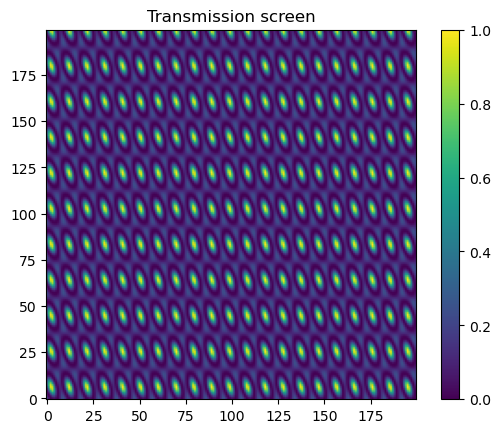

In [33]:
# example response screen

#complex_response, transmission_response = inst_response_and_transmission(A_vec=A_vec_2, x_vec=x_vec_2, phi_dc_vec_rad=phi_dc_vec_rad_2, theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m, plot=True)
complex_response, transmission_response = inst_response_and_transmission(A_vec=A_vec_3, x_vec=x_vec_3, phi_dc_vec_rad=phi_dc_vec_rad_3, theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m, plot=False)

plt.imshow(transmission_response[0,:,:], origin='lower')
plt.colorbar()
plt.title('Transmission screen')
plt.show()

In [34]:
# example conical-density disk passed through the transmission screen
def astro_cube_cone():

    # cube to hold the scene and on-sky coordinates
    astro_cube = np.zeros((3, N, N), dtype=float)

    # Create on-sky grid coordinates (x and y) in arcseconds
    x = np.arange(N) - N // 2
    y = np.arange(N) - N // 2
    X, Y = np.meshgrid(x, y)

    # Create a centered circular astrophysical source with max N at center, dropping to zero at edge
    radius_pixels = N // 6  # adjustable; makes a circle about 1/3 across

    astro_scene = np.zeros((N, N), dtype=float)

    # Compute radial distance from center for each pixel
    # Here, (X, Y) are already created as meshgrids above, ranging symmetrically around zero
    rr = np.sqrt(X**2 + Y**2)

    # Center the circle by definition: at (0,0) in meshgrid coordinates
    circle_mask = rr <= radius_pixels

    # Linear dropoff: N at center, 0 at edge, fully centered
    astro_scene[circle_mask] = N * (1 - rr[circle_mask]/radius_pixels)

    # Slices 2 and 3: x and y coordinates in arcseconds
    x_asec = (X) * pixel_scale_onsky
    y_asec = (Y) * pixel_scale_onsky

    # add the scene and coordinates
    astro_cube[0] = astro_scene
    astro_cube[1] = y_asec
    astro_cube[2] = x_asec

    return astro_cube


# example off-axis point source
def astro_cube_planet():

    # cube to hold the scene and on-sky coordinates
    astro_cube = np.zeros((3, N, N), dtype=float)

    # Create on-sky grid coordinates (x and y) in arcseconds
    x = np.arange(N) - N // 2
    y = np.arange(N) - N // 2
    X, Y = np.meshgrid(x, y)

    # Create an off-axis point source at radius R from the center

    # Specify the desired separation from center in pixels
    R = N // 4  # adjustable; off-axis radius (e.g. 1/4 image width)

    astro_scene = np.zeros((N, N), dtype=float)

    # Position the point source along the +x axis at (x0, y0)
    x0 = N // 2 + R
    y0 = N // 2

    # Place the point source (set intensity to 1)
    if 0 <= x0 < N and 0 <= y0 < N:
        astro_scene[y0, x0] = 1.0

    # Slices 2 and 3: x and y coordinates in arcseconds
    x_asec = (X) * pixel_scale_onsky
    y_asec = (Y) * pixel_scale_onsky

    # add the scene and coordinates
    astro_cube[0] = astro_scene
    astro_cube[1] = y_asec
    astro_cube[2] = x_asec

    return astro_cube


In [35]:
# Plot astrophysical scene, transmission screen, and the product in a single row of subplots

scene_exozodi_disk = astro_cube_cone()
scene_off_axis_planet = astro_cube_planet()

exozodi_times_transmission = scene_exozodi_disk[0] * transmission_response[0,:,:]
scene_off_axis_planet_times_transmission = scene_off_axis_planet[0] * transmission_response[0,:,:]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(scene_exozodi_disk[0], origin='lower')
axes[0].set_title("Astrophysical scene: exozodi")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(transmission_response[0,:,:], origin='lower')
axes[1].set_title("Transmission screen")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(exozodi_times_transmission, origin='lower')
axes[2].set_title("Scene × Transmission")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()

plt.savefig('junk_exozodi_times_transmission.png')
#plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(scene_off_axis_planet[0], origin='lower')
axes[0].set_title("Astrophysical scene: planet")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(transmission_response[0,:,:], origin='lower')
axes[1].set_title("Transmission screen")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(scene_off_axis_planet_times_transmission, origin='lower')
axes[2].set_title("Scene × Transmission")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()

plt.savefig('junk_off_axis_planet_times_transmission.png')
#plt.show()


In [37]:
# take several frames where the planet rotates within the transmission screen, and plot the summed transmitted signal as a function of rotation angle

# Set up rotation angles (full 360 degrees)
n_angles = 400  # number of sampled steps in the rotation
rotation_angles = np.linspace(0, 360, n_angles, endpoint=False)  # degrees

# Initialize array to store summed transmitted signals
summed_transmitted_signal = np.zeros(n_angles)

# Loop over rotation angles
for i, angle in enumerate(rotation_angles):

    # rotated the chosen scene
    #rotated_scene = scipy_rotate(scene_off_axis_planet[0,:,:], angle=angle, reshape=False, order=1, mode='constant', cval=0.0)
    rotated_scene = scipy_rotate(scene_exozodi_disk[0,:,:], angle=angle, reshape=False, order=1, mode='constant', cval=0.0)
    
    # Compute transmitted signal: scene × transmission
    transmitted_signal = rotated_scene * transmission_response[0, :, :]
    
    # Sum the transmitted signal
    summed_transmitted_signal[i] = np.sum(transmitted_signal)

# Plot the summed transmitted signal as a function of rotation angle
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(rotation_angles, summed_transmitted_signal, 'b-', linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Rotation Angle [degrees]', fontsize=12)
ax.set_ylabel('Summed Transmitted Signal', fontsize=12)
ax.set_title('Transmitted Signal vs Rotation Angle', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 360)
plt.tight_layout()
plt.savefig('junk_planet_rotation_transmission_signal.png')
#plt.show()


In [ ]:
## Photon rate, Method 1: Split astrophysical source into (a)symmetric components and separately take FTs

In [17]:
def symm_asymm_scene(scene, plot=False):
    '''
    INPUTS:
    scene: 2D array of the astrophysical scene
    plot: boolean, if True, plot the symmetrical and asymmetrical parts

    OUTPUTS:
    scene_symm: 2D array of the symmetrical part of the astrophysical scene
    scene_asymm: 2D array of the asymmetrical part of the astrophysical scene
    '''

    # generate the (a)symmetrical parts of the astrophysical source
    scene_flipped = np.flip(np.flip(scene, axis=0), axis=1)

    scene_symm = (scene + scene_flipped) / 2
    scene_asymm = (scene - scene_flipped) / 2

    if plot:
        plt.clf()
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        im0 = axes[0].imshow(scene_symm, origin='lower')
        axes[0].set_title('Astrophysical scene, symmetrical part')
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
        im1 = axes[1].imshow(scene_asymm, origin='lower')
        axes[1].set_title('Astrophysical scene, asymmetrical part')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        
        

    return scene_symm, scene_asymm

<Figure size 640x480 with 0 Axes>

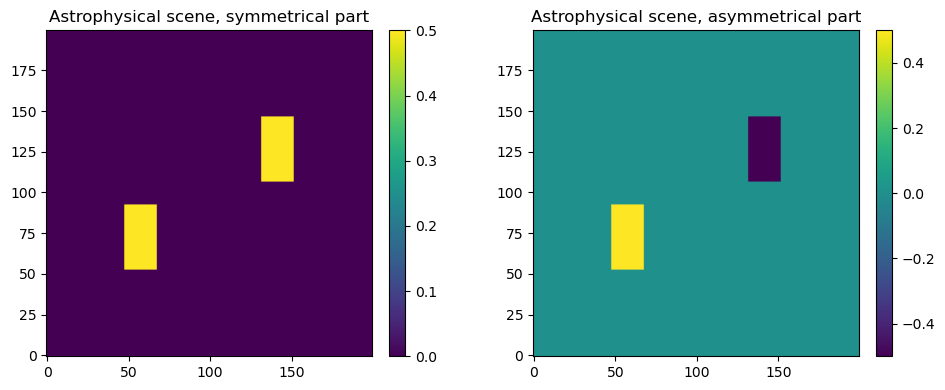

In [18]:
scene_symm_test, scene_asymm_test = symm_asymm_scene(astro_cube[0,:,:], plot=True)

In [35]:
def B_twiddle_sky_symm_asymm(B_sky_symm, B_sky_asymm, x_vec_j, x_vec_k, theta_vec_2d_asec, wavel_m, plot=False):
    '''
    Definition of scalar B_twiddle, for (a)symmetrical parts of the astrophysical source 
    (Eqn. B18, Dannert 2025)

    INPUTS:
    B_sky_symm: symmetrical part of the astrophysical scene, as a 2D array
    B_sky_asymm: ditto for the asymmetrical part
    x_vec: array of vectors of aperture positions (y,x) [m]; ex. np.array(([0, -1], [0, 1], [1, 1]))
    theta_vec_2d_asec: cube of theta_vec coordinateswith slice 0 = y_asec, slice 1 = x_asec; ex. theta_vec_2d_asec[1:,:,:]
    wavel_m: wavelength in meters
    plot: boolean, if True, plot the intermediate results

    RETURNS:
    B_twiddle_sky_symm_baseline_this: scalar of the symmetrical part of the B_twiddle, for this baseline
    B_twiddle_sky_asymm_baseline_this: ditto for the asymmetrical part
    '''

    del_x_jk = x_vec_k - x_vec_j

    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)

    phase_term = (2 * np.pi / wavel_m) * (
        del_x_jk[0] * theta_vec_rad_array[0] +  # y component
        del_x_jk[1] * theta_vec_rad_array[1]    # x component
    )

    # Extract the scene data from the cubes (slice [0] contains the 2D scene array)

    # integrate by summing over the pixel solid angles
    d_omega = np.abs(theta_vec_rad_array[0,1,0]-theta_vec_rad_array[0,0,0]) * np.abs(theta_vec_rad_array[1,0,1]-theta_vec_rad_array[1,0,0]) # one pixel

    '''
    plt.imshow(theta_vec_rad_array[0,:,:], origin='lower')
    plt.title('theta_vec_rad_array_0')
    plt.colorbar()
    plt.show()

    plt.imshow(theta_vec_rad_array[1,:,:], origin='lower')
    plt.title('theta_vec_rad_array_1')
    plt.colorbar()
    plt.show()
    '''

    # Compute the integral: sum over all sky positions
    B_twiddle_sky_symm_baseline_this = np.sum( B_sky_symm * np.cos(phase_term) * d_omega )
    B_twiddle_sky_asymm_baseline_this = -1j * np.sum( B_sky_asymm * np.sin(phase_term) * d_omega )

    '''
    print('B_twiddle_sky_symm_baseline_this')
    print(B_twiddle_sky_symm_baseline_this)

    print('B_twiddle_sky_asymm_baseline_this')
    print(B_twiddle_sky_asymm_baseline_this)
    '''

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        im0 = axs[0].imshow(np.cos(phase_term), origin='lower')
        axs[0].set_title('Transmissive response:\ncos(phase_term)')
        plt.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(np.sin(phase_term), origin='lower')
        axs[1].set_title('Transmissive response:\nsin(phase_term)')
        plt.colorbar(im1, ax=axs[1])

        im2 = axs[2].imshow(B_sky_symm * np.cos(phase_term), origin='lower')
        axs[2].set_title('Scene multiplied by transmissive response:\nB_sky_symm * cos(phase_term)')
        plt.colorbar(im2, ax=axs[2])

        im3 = axs[3].imshow(B_sky_asymm * np.sin(phase_term), origin='lower')
        axs[3].set_title('Scene multiplied by transmissive response:\nB_sky_asymm * sin(phase_term)')
        plt.colorbar(im3, ax=axs[3])

        plt.tight_layout()
        plt.show()

    return B_twiddle_sky_symm_baseline_this, B_twiddle_sky_asymm_baseline_this

B_twiddle_sky_symm_baseline_this
-4.6484438335726735e-14
B_twiddle_sky_asymm_baseline_this
5.802111275712862e-14j


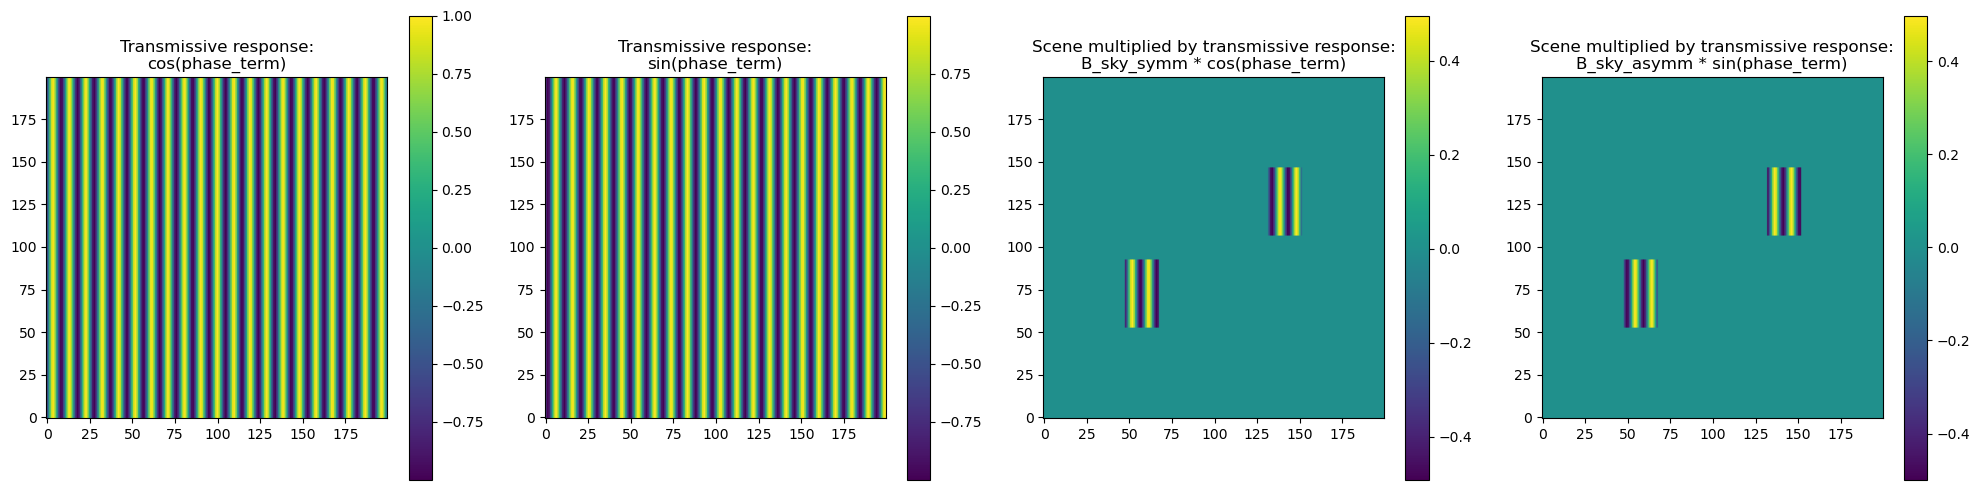

(np.float64(-4.6484438335726735e-14), 5.802111275712862e-14j)


In [29]:
test = B_twiddle_sky_symm_asymm(B_sky_symm=scene_symm_test, B_sky_asymm=scene_asymm_test, x_vec_j=x_vec[0], x_vec_k=x_vec[1], theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m, plot=True)
print(test)

In [36]:
def photon_rate_1(del_wavel, A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m, astro_scene, incl_comp_transmission=False):
    '''
    Finds rate of incoming photons (Eqn. B19, Dannert 2025, without polarization for now), using method of effectively FTing the (a)symmetrical parts of the astrophysical source separately
    
    INPUTS:
    del_wavel: bandpass [m]
    A_vec: array of amplitudes
    x_vec: array of vectors of aperture positions (y,x) [m]
    phi_dc_vec_rad: array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
    theta_vec_2d_asec: canvas of on-sky coordinates; cube with slice 0 = y_asec, slice 1 = x_asec
    wavel_m: wavelength in meters
    astro_scene: 2D array of the astrophysical scene
    incl_comp_transmission: boolean, if True, include the writing out of the transmissions of the component baselines in slices 1 to -3

    OUTPUT:
    R_theta_vec: instrument response over the sky; slices are
      [0] = total instrument response
      [1:-3] = instrument responses of the component baselines (if flag is set)
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    '''

    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec
    # Vectorized version that works for arbitrary number of apertures

    # split astrophysical scene into symmetrical and asymmetrical parts
    scene_symm, scene_asymm = symm_asymm_scene(astro_scene, plot=False)

    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)
    
    # Get number of apertures
    N_apertures = len(A_vec)
    
    # Initialize the instrument response array
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))  # shape: (Ny, Nx)
    
    # Calculate total number of baselines (unique pairs of apertures)
    # For N apertures, number of unique baselines = N*(N-1)/2
    N_baselines = N_apertures * (N_apertures - 1) // 2
    print(f'Total number of baselines: {N_baselines}')

    cube_canvas = np.zeros((3, N, N))

    summ_term_net = 0 # initialize the summation term in Eqn. B19

    # Sum over all pairs of apertures (j, k) where j < k
    for j in range(N_apertures):
        for k in range(j + 1, N_apertures):

            # Differential phase between apertures j and k [rad]
            del_phi_dc_jk_rad = phi_dc_vec_rad[k] - phi_dc_vec_rad[j]
            
            # Baseline from aperture j to aperture k [m]
            del_x_jk = x_vec[k] - x_vec[j]  # shape: (2,)

            # argument x_jk/lambda
            arg_x_jk_lambda = (del_x_jk / wavel_m)

            # now comes the astrophysical scene: get the B-twiddle parts for this baseline
            B_twiddle_symm, B_twiddle_asymm = B_twiddle_sky_symm_asymm(B_sky_symm=scene_symm, B_sky_asymm=scene_asymm, x_vec_j=x_vec[j], x_vec_k=x_vec[k], theta_vec_2d_asec=theta_vec_2d_asec, wavel_m=wavel_m, plot=False)

            # term to be summed over baselines in Eqn. B19
            summ_term_this_baseline = A_vec[j] * A_vec[k] * ( np.cos(del_phi_dc_jk_rad) * B_twiddle_symm - 1j * np.sin(del_phi_dc_jk_rad) * B_twiddle_asymm )

            summ_term_net += summ_term_this_baseline

    # net photon rate
    n_tot = del_wavel * summ_term_net
    
    return n_tot

In [37]:
# example photon rate

photon_rate_example = photon_rate_1(del_wavel=3e-6, A_vec=A_vec, x_vec=x_vec, phi_dc_vec_rad=phi_dc_vec_rad, theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m, astro_scene=astro_cube[0,:,:], incl_comp_transmission=False)

print('Photon rate:', photon_rate_example)

Total number of baselines: 3
Photon rate: (-2.0141473365420615e-19+0j)


In [ ]:
## THE BELOW IS IN DEV

/var/folders/wb/zn41c4yx58z1ktmcwgv62zyr0000gn/T/ipykernel_53932/4219824121.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(test_new_fft)), origin='lower')


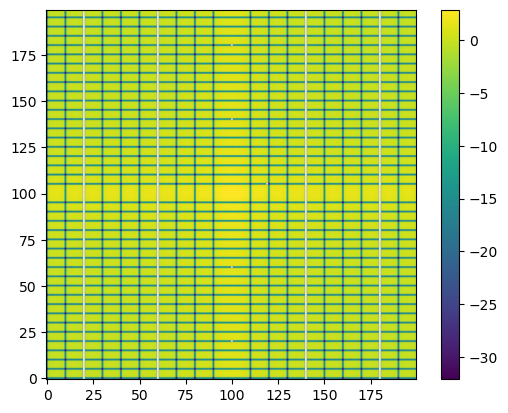

In [ ]:
# In dev: FFT of a scene
test_new_fft = np.fft.fftshift(np.fft.fft2(astro_cube[0,:,:]))

plt.imshow(np.log10(np.abs(test_new_fft)), origin='lower')
plt.colorbar()
plt.show()



In [28]:
def fft_of_astro(astro_cube):
    '''
    Take FFT of an astrophysical scene

    INPUTS:
    astro_cube: 3D array with slices [0] = scene, [1] = y [arcsec], [2] = x [arcsec]

    OUTPUTS:
    fft_cube: 3D array with slices [0] = complex FFT of response, [1] = fy (cycles per arcsec), [2] = fx (cycles per arcsec)
    '''

    # Build FFT cube with associated spatial-frequency coordinates
    # test_new[0,:,:] is on a regular sky grid with pixel scale 'pixel_scale_onsky' [arcsec/pixel]
    # Here we attach frequency-space coordinates (cycles per arcsec) for y and x.

    Ny, Nx = test_new[0].shape

    pixel_scale_onsky = astro_cube[1,0,1] - astro_cube[1,0,0]

    # Spatial-frequency coordinates (cycles per arcsec)
    # np.fft.fftfreq uses spacing 'd' in arcsec/pixel, so output is cycles/arcsec
    freq_y = np.fft.fftshift(np.fft.fftfreq(Ny, d=pixel_scale_onsky))  # row (y) frequencies
    freq_x = np.fft.fftshift(np.fft.fftfreq(Nx, d=pixel_scale_onsky))  # column (x) frequencies

    # Make 2D grids so each Fourier pixel has its (fy, fx)
    fx_grid, fy_grid = np.meshgrid(freq_x, freq_y)  # shapes (Ny, Nx)

    # Build a cube analogous to astro_cube / test_new:
    #   [0] = complex FFT of response
    #   [1] = fy (cycles per arcsec)
    #   [2] = fx (cycles per arcsec)

    fft_cube = np.zeros((3, Ny, Nx), dtype=complex)
    fft_cube[0] = test_new_fft
    fft_cube[1] = fy_grid
    fft_cube[2] = fx_grid

    print(fy_grid)

    # Add a top row of subplots to show the input astrophysical scene and coordinates.

    # Consolidate all subplots into a single figure with six axes
    fig, axes = plt.subplots(3, 3, figsize=(14, 8))

    # Top row: input scene and coordinates
    im00 = axes[0, 0].imshow(astro_cube[0], origin="lower")
    axes[0, 0].set_title("Input Scene")
    plt.colorbar(im00, ax=axes[0, 0])

    im01 = axes[0, 1].imshow(astro_cube[1], origin="lower")
    axes[0, 1].set_title("Y [arcsec]")
    plt.colorbar(im01, ax=axes[0, 1])

    im02 = axes[0, 2].imshow(astro_cube[2], origin="lower")
    axes[0, 2].set_title("X [arcsec]")
    plt.colorbar(im02, ax=axes[0, 2])

    # Middle row: Fourier plots
    im10 = axes[1, 0].imshow(np.log10(np.abs(fft_cube[0]) + 1e-12), origin="lower")
    axes[1, 0].set_title("log10 |FFT(response)|")
    plt.colorbar(im10, ax=axes[1, 0])

    im11 = axes[1, 1].imshow(fft_cube[0].real, origin="lower")
    axes[1, 1].set_title("Re{FFT(response)}")
    plt.colorbar(im11, ax=axes[1, 1])

    im12 = axes[1, 2].imshow(fft_cube[0].imag, origin="lower")
    axes[1, 2].set_title("Im{FFT(response)}")
    plt.colorbar(im12, ax=axes[1, 2])

    # Bottom row: Fourier-space coordinates (two subplots only)
    im20 = axes[2, 0].imshow(fft_cube[1,:,:], origin="lower")   
    axes[2, 0].set_title("fy [cycles/arcsec]")
    plt.colorbar(im20, ax=axes[2, 0])

    im21 = axes[2, 1].imshow(fft_cube[2,:,:], origin="lower")
    axes[2, 1].set_title("fx [cycles/arcsec]")
    plt.colorbar(im21, ax=axes[2, 1])

    plt.tight_layout()
    plt.show()

    return fft_cube


[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [ inf  inf  inf ...  inf  inf  inf]
 [ inf  inf  inf ...  inf  inf  inf]
 [ inf  inf  inf ...  inf  inf  inf]]


/Users/eckhartspalding/miniconda3/envs/life/lib/python3.10/site-packages/numpy/fft/_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/eckhartspalding/miniconda3/envs/life/lib/python3.10/site-packages/numpy/fft/_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val


TypeError: Image data of dtype complex128 cannot be converted to float

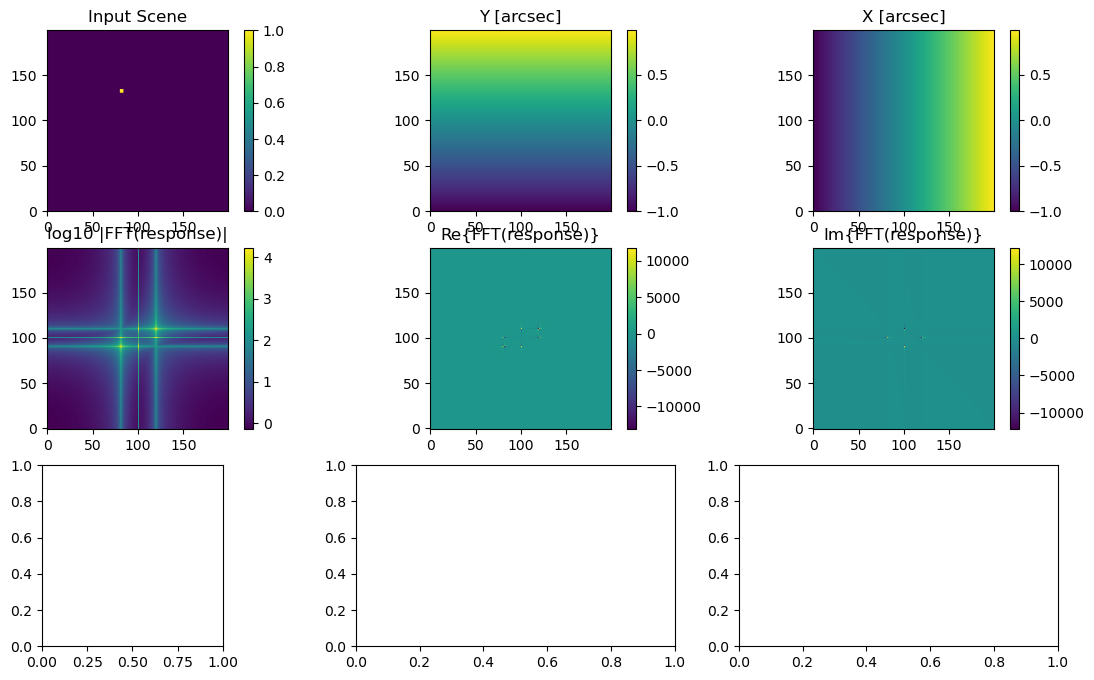

In [ ]:
scene_astrophysical = astro_cube
test = fft_of_astro(astro_cube)

In [ ]:
print(np.max(test_new[0,:,:]))
print(np.min(test_new[0,:,:]))

2.999784538515729
-1.4999169567854085
